TensorFlow version: 2.13.0
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Image downloaded and saved to /var/folders/rc/d6k86flj4h15dpncq9zmhhmh0000gn/T/tmp4prdclkp.jpg.


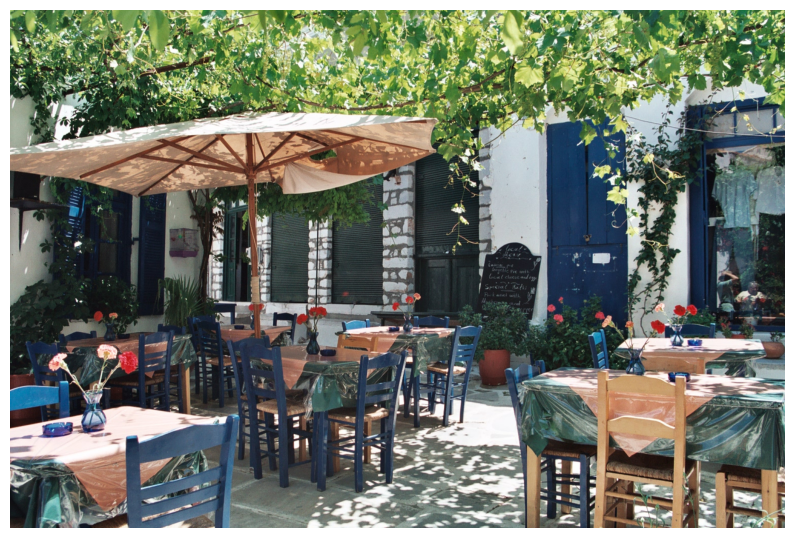

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2024-12-10 21:59:56.781181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-10 22:00:10.184442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Found 100 objects in 31.01 seconds.
Annotated image saved to output.jpg.


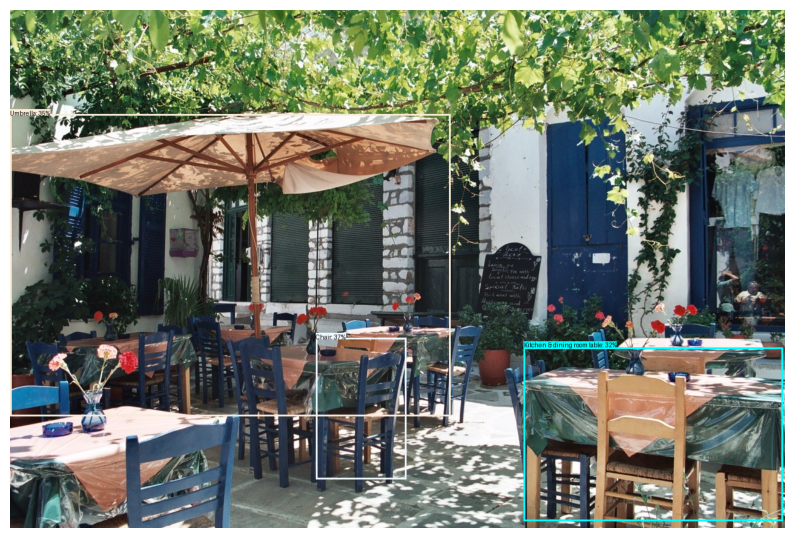

In [24]:
# Enhanced Object Detection Script

# Imports
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
import tempfile
from urllib.request import urlopen
from io import BytesIO
import os
import time

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"Available GPU devices: {tf.config.list_physical_devices('GPU')}")

# Function to display an image
def display_image(image):
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

# Function to download or load an image, resize, and optionally display it
def load_and_preprocess_image(image_path, new_width=256, new_height=256, display=False):
    if image_path.startswith("http://") or image_path.startswith("https://"):
        # Download image from URL
        _, filename = tempfile.mkstemp(suffix=".jpg")
        response = urlopen(image_path)
        image_data = response.read()
        image = Image.open(BytesIO(image_data))
        image = ImageOps.fit(image, (new_width, new_height), Image.LANCZOS)
        image.save(filename, format="JPEG", quality=90)
        print(f"Image downloaded and saved to {filename}.")
    else:
        # Load local image
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Local file {image_path} not found.")
        image = Image.open(image_path)
        image = ImageOps.fit(image, (new_width, new_height), Image.LANCZOS)
        filename = image_path
    
    if display:
        display_image(image)
    return filename

# Function to draw bounding boxes on the image
def draw_bounding_box(image, ymin, xmin, ymax, xmax, label, score, color, font):
    """
    Draws a bounding box with a label and score on the image.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    
    # Draw the rectangle
    draw.rectangle([(left, top), (right, bottom)], outline=color, width=3)
    
    # Add label and score
    if label:
        display_str = f"{label}: {int(score * 100)}%"
        
        # Use font.getbbox() instead of font.getsize()
        bbox = font.getbbox(display_str)  # Get bounding box of the text
        text_width, text_height = bbox[2], bbox[3] - bbox[1]  # Calculate width and height
        
        # Draw background rectangle for text
        draw.rectangle([(left, top - text_height), (left + text_width, top)], fill=color)
        
        # Draw the text
        draw.text((left, top - text_height), display_str, fill="black", font=font)

# Function to annotate image with detected objects
def annotate_image(image_path, detector, output_path=None, max_boxes=10, min_score=0.2):
    image = Image.open(image_path).convert("RGB")
    img_array = np.array(image)
    converted_img = tf.image.convert_image_dtype(img_array, tf.float32)[tf.newaxis, ...]
    
    start_time = time.time()
    detections = detector(converted_img)
    end_time = time.time()

    detections = {key: value.numpy() for key, value in detections.items()}
    print(f"Found {len(detections['detection_scores'])} objects in {end_time - start_time:.2f} seconds.")

    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    for i in range(min(len(detections['detection_boxes']), max_boxes)):
        if detections['detection_scores'][i] >= min_score:
            ymin, xmin, ymax, xmax = detections['detection_boxes'][i]
            label = detections['detection_class_entities'][i].decode("ascii")
            score = detections['detection_scores'][i]
            color = colors[i % len(colors)]
            draw_bounding_box(image, ymin, xmin, ymax, xmax, label, score, color, font)

    if output_path:
        image.save(output_path)
        print(f"Annotated image saved to {output_path}.")
    display_image(image)

# Main workflow
if __name__ == "__main__":
    # Image source: Local or URL
    image_path = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  # Replace with a local path or another URL
    processed_image_path = load_and_preprocess_image(image_path, 1280, 856, display=True)

    # Load the latest detection model
    model_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
    detector = hub.load(model_url).signatures['default']

    # Annotate the image
    output_image_path = "output.jpg"  # Specify output path for annotated image
    annotate_image(processed_image_path, detector, output_image_path, max_boxes=15, min_score=0.3)

Image downloaded to input_image.jpg

image 1/1 /Users/dheeraj/Desktop/ml/final obj.det/input_image.jpg: 480x640 1 cup, 130.0ms
Speed: 38.0ms preprocess, 130.0ms inference, 19.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2
Detected objects:
Class: tensor([41.]), Confidence: tensor([0.9469]), Box: tensor([[496.9567, 328.5492, 735.3257, 517.9388]])
Annotated image saved to runs/detect/predict/input_image.jpg


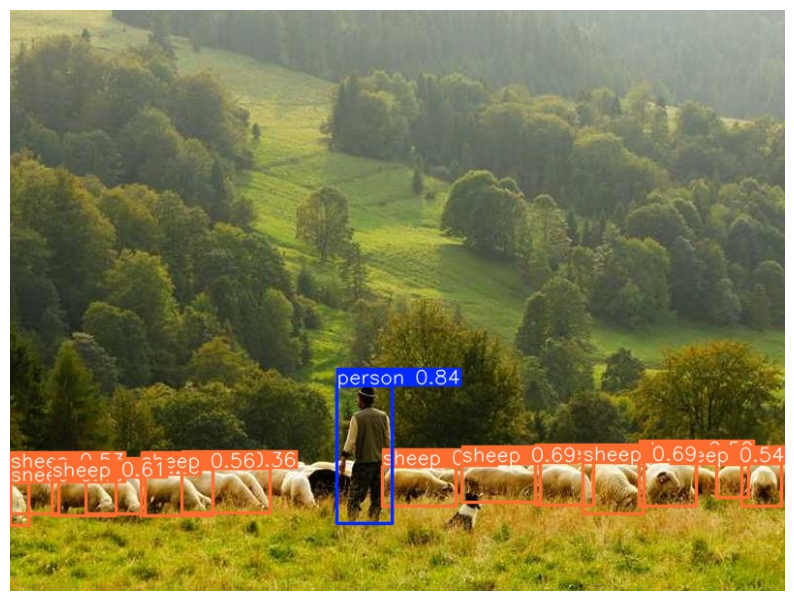

In [25]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os
def display_image(image_path):
    """Display an image using matplotlib."""
    image = Image.open(image_path)
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

# Function to download an image from a URL
def download_image(url, output_path="input_image.jpg"):
    """Download an image from the web."""
    response = requests.get(url)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            f.write(response.content)
        print(f"Image downloaded to {output_path}")
        return output_path
    else:
        raise Exception(f"Failed to download image from {url}. Status code: {response.status_code}")

# Function to run YOLOv10 inference
def run_yolo_inference(image_path, model_path='yolov8n.pt', output_dir='runs/detect'):
    """
    Run YOLOv10 object detection on an image.
    Args:
        image_path (str): Path to the input image.
        model_path (str): Path to the YOLOv10 model weights.
        output_dir (str): Directory to save the annotated results.
    """
    # Load the YOLOv10 model
    model = YOLO(model_path)  # Pre-trained weights or your custom-trained model

    # Run inference
    results = model.predict(source=image_path, save=True, project=output_dir)

    # Get the path of the annotated image
    annotated_image_path = os.path.join(output_dir, "predict", os.path.basename(image_path))
    
    # Display the results
    print("Detected objects:")
    for result in results:
        for box in result.boxes:
            print(f"Class: {box.cls}, Confidence: {box.conf}, Box: {box.xyxy}")

    print(f"Annotated image saved to {annotated_image_path}")
    return annotated_image_path
if __name__ == "__main__":
    # Specify the image URL
    image_url = 'https://picsum.photos/800/600'
    
    # Specify paths for input and output
    input_image_path = "input_image.jpg"
    output_directory = "runs/detect"
    model_weights = "yolov8n.pt"  # Replace with your YOLOv10 weights path
    
    # Download the image
    input_image_path = download_image(image_url, input_image_path)
    
    # Run YOLO inference
    annotated_image = run_yolo_inference(input_image_path, model_weights, output_directory)
    
    # Display the annotated image
    display_image(annotated_image)